# 1 - Model Overview
Each word of the sentence goes through embeddings, LSTM (long short term memory) and dropout layers. 

The last layer of the network is softmax which chooses the best emoji for this sentence.

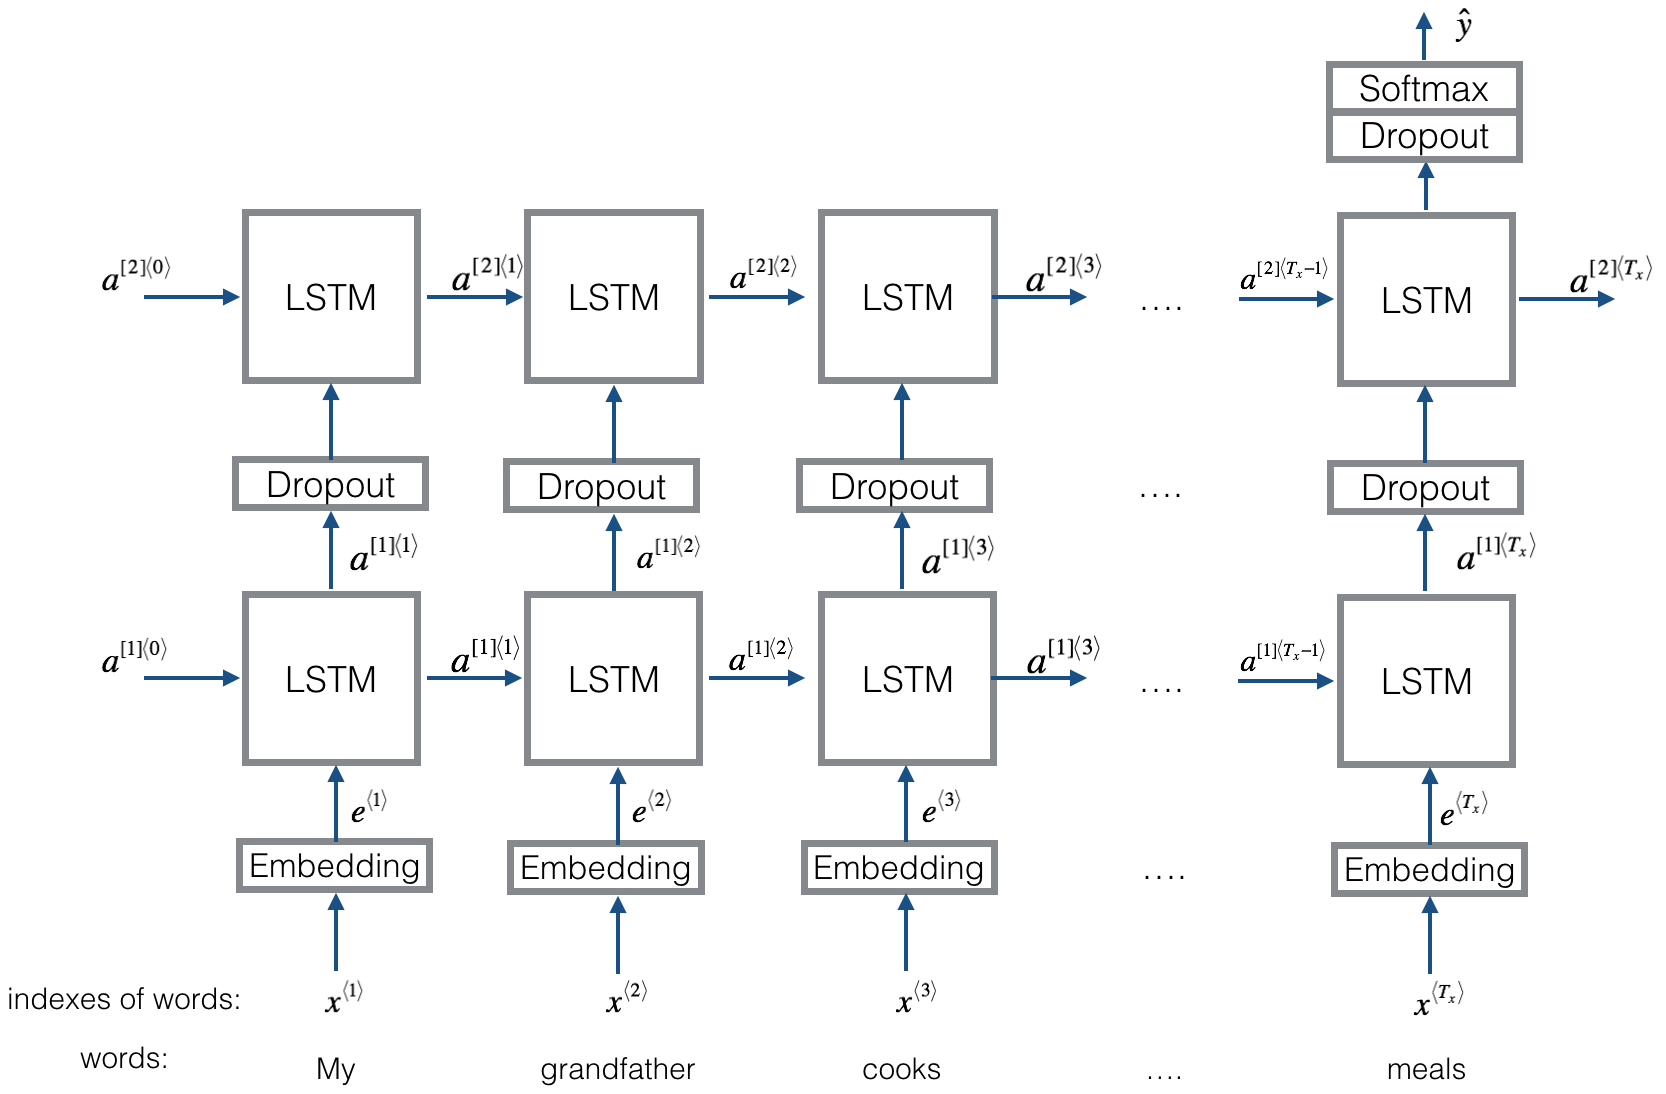

# 2 - Necessary imports
This network will be based on keras layers: Dense, Dropout, LSTM, Activation.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform

%matplotlib inline

# 3 - Creating utility methods for the model
Methods that help to load the data from CSV, compute softmax, and a few more.

In [16]:
import csv
import pandas as pd
import emoji 
from sklearn.metrics import confusion_matrix

In [7]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [23]:
def read_csv(filename = 'data/emojify_data.csv'):
    phrase = []
    emoji = []
    
    with open (filename) as csvDataFile:
        csvReader = csv.reader(csvDataFile)
        for row in csvReader:
            phrase.append(row[0])
            emoji.append(row[1])
    
    X = np.asarray(phrase)
    Y = np.asarray(emoji, dtype=int)
    
    return X, Y

In [21]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
            
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
        
    return words_to_index, index_to_words, word_to_vec_map

In [11]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [31]:
emoji_dictionary = {
    "0": "\u2764\uFE0F",
    "1": ":baseball:",
    "2": ":smile:",
    "3": ":disappointed:",
    "4": ":fork_and_knife:"
}

In [37]:
def label_to_emoji(label):
    return emoji.emojize(emoji_dictionary[str(label)], language='alias')

# 3 - Importing sets
Importing the training & testing sets.

In [24]:
X_train, Y_train = read_csv('data/train_emoji.csv')
X_test, Y_test = read_csv('data/tests.csv')

In [51]:
max_len = len(max(X_train, key=len).split())

### Training example
Training example looks like this:

In [38]:
for idx in range(4):
    print(X_train[idx], label_to_emoji(Y_train[idx]))

never talk to me again 😞
I am proud of your achievements 😄
It is the worst day in my life 😞
Miss you so much ❤️


## Importing pre-trained embedding maps
This file can be downloaded from kaggle: https://www.kaggle.com/datasets/watts2/glove6b50dtxt?resource=download

In [45]:
# In the model we'll use these pretrained maps from the glove file
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/glove.6B.50d.txt')

# 4 - Creating a model
Creating the model structure.

In [40]:
def sentences_to_indices(X, word_to_index, max_len):
    m = X.shape[0]
    
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):
        sentence_words = X[i].lower().split()
        
        j = 0
        for w in sentence_words:
            if w in word_to_index:
                X_indices[i, j] = word_to_index[w]
                j = j + 1
                
    return X_indices

In [41]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    vocab_size = len(word_to_index) + 1
    any_word =list(word_to_vec_map.keys())[0]
    emb_dim = word_to_vec_map[any_word].shape[0]
    
    emb_matrix = np.zeros((vocab_size, emb_dim))
    
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]
        
    embedding_layer = Embedding(vocab_size, emb_dim, trainable=False)
    embedding_layer.build((None, ))
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [48]:
def NetworkModel(input_shape, word_to_vec_map, word_to_index):
    sentence_indices = Input(input_shape, dtype='int32')
    
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    embeddings = embedding_layer(sentence_indices)
    
    X = LSTM(128, return_sequences=True)(embeddings)
    X = Dropout(0.5)(X)
    X = LSTM(128, return_sequences=False)(X)
    X = Dropout(0.5)(X)
    X = Dense(5)(X)
    X = Activation('softmax')(X)
    
    model = Model(sentence_indices, X)
    
    return model

In [52]:
model = NetworkModel((max_len, ), word_to_vec_map, word_to_index)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 10, 50)            20000050  
                                                                 
 lstm_4 (LSTM)               (None, 10, 128)           91648     
                                                                 
 dropout_4 (Dropout)         (None, 10, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 5)                 645 

# 5 - Compiling, Training, Testing
Compiling, training & testing the model.

In [53]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [54]:
X_train_indices = sentences_to_indices(X_train, word_to_index, max_len)
Y_train_onehot = convert_to_one_hot(Y_train, C = 5)

In [55]:
model.fit(X_train_indices, Y_train_onehot, epochs=50, batch_size=32, shuffle=True)

Epoch 1/50
5/5 [==============================] - 1s 14ms/step - loss: 1.5943 - accuracy: 0.1818
Epoch 2/50
5/5 [==============================] - 0s 12ms/step - loss: 1.4852 - accuracy: 0.2879
Epoch 3/50
5/5 [==============================] - 0s 9ms/step - loss: 1.4583 - accuracy: 0.3712
Epoch 4/50
5/5 [==============================] - 0s 9ms/step - loss: 1.3463 - accuracy: 0.5000
Epoch 5/50
5/5 [==============================] - 0s 9ms/step - loss: 1.2612 - accuracy: 0.6212
Epoch 6/50
5/5 [==============================] - 0s 9ms/step - loss: 1.1324 - accuracy: 0.6288
Epoch 7/50
5/5 [==============================] - 0s 9ms/step - loss: 1.0449 - accuracy: 0.6364
Epoch 8/50
5/5 [==============================] - 0s 9ms/step - loss: 0.8720 - accuracy: 0.7045
Epoch 9/50
5/5 [==============================] - 0s 10ms/step - loss: 0.7899 - accuracy: 0.6818
Epoch 10/50
5/5 [==============================] - 0s 10ms/step - loss: 0.8507 - accuracy: 0.6439
Epoch 11/50
5/5 [==================

In [56]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len)
Y_test_onehot = convert_to_one_hot(Y_test, C = 5)

loss, acc = model.evaluate(X_test_indices, Y_test_onehot)
print('\nTest accuracy = ', acc)

2/2 [==============================] - 0s 5ms/step - loss: 0.4329 - accuracy: 0.8750

Test accuracy =  0.875


### Mislabeled examples
A lot of predictions for mislabeled examples give good emojis. This actually shows that the model has a higher accuracy than 87.5% because most predictions could be used in the real-life scenario by a human.

In [60]:
y_test_onehot = np.eye(5)[Y_test.reshape(-1)]
x_test_indices = sentences_to_indices(X_test, word_to_index, max_len)
pred = model.predict(x_test_indices)

for i in range(len(X_test)):
    x = x_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print('Expected emoji:' + label_to_emoji(Y_test[i]) + ' prediction: ' + X_test[i] + label_to_emoji(num).strip())

2/2 [==============================] - 0s 5ms/step
Expected emoji:😞 prediction: work is hard	😄
Expected emoji:😞 prediction: This girl is messing with me	❤️
Expected emoji:😞 prediction: work is horrible	😄
Expected emoji:😄 prediction: you brighten my day	❤️
Expected emoji:😞 prediction: she is a bully	😄
Expected emoji:😞 prediction: My life is so boring	❤️
Expected emoji:😄 prediction: will you be my valentine	❤️


### Testing on custom sentence
Let's see what the model gives for other, custom sentences.

In [63]:
x_test = np.array(["not feeling happy"])
x_test_indices = sentences_to_indices(x_test, word_to_index, max_len)
print(x_test[0] + ' ' +  label_to_emoji(np.argmax(model.predict(x_test_indices))))

1/1 [==============================] - 0s 21ms/step
not feeling happy 😞


In [65]:
x_test = np.array(["i want to play sports"])
x_test_indices = sentences_to_indices(x_test, word_to_index, max_len)
print(x_test[0] + ' ' +  label_to_emoji(np.argmax(model.predict(x_test_indices))))

1/1 [==============================] - 0s 25ms/step
i want to play sports ⚾
